# ML in Cybersecurity: Task II

## Team
  * **Team name**:  *R2D2C3P0BB8*
  * **Members**:  <br/> **Navdeeppal Singh (s8nlsing@stud.uni-saarland.de)** <br/> **Shahrukh Khan (shkh00001@stud.uni-saarland.de)** <br/> **Mahnoor Shahid (mash00001@stud.uni-saarland.de)**


## Logistics
  * **Due date**: 25th Nov. 2021, 23:59:59 (email the completed notebook including outputs to mlcysec_ws2022_staff@lists.cispa.saarland)
  * Email the completed notebook to mlcysec_ws2022_staff@lists.cispa.saarland 
  * Complete this in the previously established **teams of 3**
  * Feel free to use the course forum to discuss.
  
  
## About this Project
In this project, we dive into the vulnerabilities of machine learning models and the difficulties of defending against them. To this end, we ask you to implement an evasion attack (craft adversarial examples) yourselves, and defend your own model.   


## A Note on Grading
The total number of points in this project is 100. We further provide the number of points achievable with each excercise. You should take particular care to document and visualize your results.

Whenever possible, please use tools like tables or figures to compare the different findings


 
## Filling-in the Notebook
You'll be submitting this very notebook that is filled-in with (all) your code and analysis. Make sure you submit one that has been previously executed in-order. (So that results/graphs are already visible upon opening it). 

The notebook you submit **should compile** (or should be self-contained and sufficiently commented). Check tutorial 1 on how to set up the Python3 environment.

It is extremely important that you **do not** re-order the existing sections. Apart from that, the code blocks that you need to fill-in are given by:
```
#
#
# ------- Your Code -------
#
#
```
Feel free to break this into multiple-cells. It's even better if you interleave explanations and code-blocks so that the entire notebook forms a readable "story".


## Code of Honor
We encourage discussing ideas and concepts with other students to help you learn and better understand the course content. However, the work you submit and present **must be original** and demonstrate your effort in solving the presented problems. **We will not tolerate** blatantly using existing solutions (such as from the internet), improper collaboration (e.g., sharing code or experimental data between groups) and plagiarism. If the honor code is not met, no points will be awarded.

 
  ---

In [5]:
import time 
 
import numpy as np 
import matplotlib.pyplot as plt 

import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 
import decimal
import pandas as pd
from sewar.full_ref import mse, rmse, psnr, uqi, ssim, ergas, scc, rase, sam, msssim, vifp, psnrb
from IPython.display import display, HTML
import seaborn as sns
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

In [6]:
# Some suggestions of our libraries that might be helpful for this project
from collections import Counter          # an even easier way to count
from multiprocessing import Pool         # for multiprocessing
from tqdm import tqdm                    # fancy progress bars
import warnings
import sklearn.metrics
# Load other libraries here.
# Keep it minimal! We should be easily able to reproduce your code.
# We only support sklearn and pytorch.
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data
from numpy import random
# We preload pytorch as an example
import torch

import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
# Please set random seed to have reproduceable results, e.g. torch.manual_seed(123)
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

In [7]:
compute_mode = 'cpu'
global device

if compute_mode == 'cpu':
    device = torch.device('cpu')
elif compute_mode == 'gpu':
    # If you are using pytorch on the GPU cluster, you have to manually specify which GPU device to use
    # It is extremely important that you *do not* spawn multi-GPU jobs.
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'    # Set device ID here
    device = torch.device('cuda')
else:
    raise ValueError('Unrecognized compute mode')
    
print(device)

cpu


#### Helpers

In case you choose to have some methods you plan to reuse during the notebook, define them here. This will avoid clutter and keep rest of the notebook succinct.

In [8]:
# data loading helper
def _get_data(DATA_PATH, TRAIN_BATCH_SIZE, TEST_BATCH_SIZE):
    try:
        """
        This method is created to split the MNIST data into training, validation and testing set accordingly 
        and load it into dataloaders. Also, to specify any transformations required to perform on the data. 
        As well as this method is being called multiple times in hyper parameter tuning where different batch 
        sizes are being tested
        ...

        Parameters
        ----------
        DATA_PATH : str
            specifies the path directory where dataset will be downloaded
        TRAIN_BATCH_SIZE : int
            specifies the batch size in the training loader
        TEST_BATCH_SIZE : int
            specifies the batch size in the training loader
            
        Returns
        -------
        train_loader, validation_loader, test_loader with the specified batch sizes 
            
        """
        tranformations = transforms.Compose([transforms.ToTensor()])
        
        mnist_training_dataset = datasets.MNIST(root=DATA_PATH+'train', train=True, download=True, transform=tranformations)
        mnist_testing_dataset = datasets.MNIST(root=DATA_PATH+'test', train=False, download=True, transform=tranformations)
        
        training_dataset, validation_dataset = random_split(mnist_training_dataset, [int(0.8*len(mnist_training_dataset)), int(0.2*len(mnist_training_dataset))])
        
        train_loader = DataLoader(training_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
        validation_loader = DataLoader(training_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=False)
        test_loader = DataLoader(mnist_testing_dataset, batch_size=TEST_BATCH_SIZE, shuffle=True)
        
        return train_loader, validation_loader, test_loader
    
    except Exception as e:
        print('Unable to get data due to ', e)
        
    
def visualize_specific_predictions(specific_predictions):
    target_values = []
    predicted_values = []
    figure = plt.figure(figsize=(20, 8))
    columns = 4
    rows = 3
    axs = []
    for index, (images, attacks, targets, w_preds_before_attack, w_preds_after_attack) in list(enumerate(specific_predictions))[:12]:
        with warnings.catch_warnings(record=True):
            axs.append( figure.add_subplot(rows, columns, index+1) )
            axs[-1].set_title(f'Correct: {targets}, Predicted Before: {w_preds_before_attack}, Predicted After: {w_preds_after_attack}', fontsize=10)
            axs[-1].axis("off")
            plt.imshow(images.cpu().detach().numpy().reshape(28, 28),cmap="gray")
            plt.imshow(attacks.cpu().detach().numpy().reshape(28, 28),cmap="gray")
    plt.show()

    
def _plot_epsilons_accuracy(x,y,title):
    sns.set(rc={"figure.figsize":(15, 8)}) 
    sns.set_style("whitegrid")
    clrs = ['grey' if (x > min(y)) else 'red' for x in y]

    sns.barplot(x= x, y=  y, palette=clrs)

    plt.xticks(fontsize=14)  
    plt.title(title, fontsize=20)
    plt.xlabel('Epsilon Values', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.grid(alpha = 0.3, linestyle = '--', linewidth = 2)
    plt.show()
    

# 1. Attacking an ML-model (30 points) 

In this section, we implement an attack ourselves. First, however, you need a model you can attack. Feel free to choose the DNN/ConvNN from task 1.



## 1.1: Setting up the model and data (4 Points)

Load the MNIST data, as done in task 1. 

Re-use the model from task 1 here and train it until it achieves reasonable accuracy (>92%).

If you have the saved checkpoint from task 1, you can load it directly. But please compute here the test accuracy using this checkpoint.  

**Hint:** In order to save computation time for the rest of exercise, you might consider having a relatively small model here.

**Hint**: You might want to save the trained model to save time later.

In [9]:
## 1. Loading data

DATA_PATH = './data/'
TRAIN_BATCH_SIZE, TEST_BATCH_SIZE = 64, 64
train_loader, validation_loader, test_loader = _get_data(DATA_PATH, TRAIN_BATCH_SIZE, TEST_BATCH_SIZE)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/train\MNIST\raw\train-images-idx3-ubyte.gz to ./data/train\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/train\MNIST\raw\train-labels-idx1-ubyte.gz to ./data/train\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/train\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data/train\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/train\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/train\MNIST\raw



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/test\MNIST\raw\train-images-idx3-ubyte.gz to ./data/test\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/test\MNIST\raw\train-labels-idx1-ubyte.gz to ./data/test\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/test\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data/test\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/test\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/test\MNIST\raw



In [10]:
## 2. Defining model

class CNN_Network(nn.Module):
    def __init__(self, model_params):
        """
        This class is created to specify the Convolutional Neural Network on which MNIST dataset is trained on, 
        validated and later tested. 
        It consist of one input layer, one output layer can consist of multiple hidden layers all of which is 
        specified by the user as provided through model_paramaters
        Size of the kernel, stride and padding can also be adjusted by the user as provided through model_paramaters
        ...

        Parameters
        ----------
        model_params : dictionary
            provides the model with the required input size, hidden layers and output size
            
            model_params = {
            'INPUT_SIZE' : int,
            'HIDDEN_LAYERS' : list(int),
            'OUTPUT_SIZE' : int,
            'KERNEL' : int,
            'STRIDE' : int,
            'PADDING' : int
        }
        """
        try:
            super(CNN_Network, self).__init__()
            
            layers = []
            
            for input_channel, out_channel in zip([model_params['INPUT_SIZE']] + model_params['HIDDEN_LAYERS'][:-1], 
                                                     model_params['HIDDEN_LAYERS'][:len(model_params['HIDDEN_LAYERS'])]):
                layers.append(nn.Conv2d(input_channel, out_channel, model_params['KERNEL'], model_params['STRIDE'], model_params['PADDING'], bias=True))
                layers.append(nn.MaxPool2d(2, 2))
                layers.append(nn.ReLU())
            layers.append(nn.Flatten(1))      
            layers.append(nn.Linear(model_params['HIDDEN_LAYERS'][-1], model_params['OUTPUT_SIZE'], bias=True))

            self.layers = nn.Sequential(*layers)
        
        except Exception as e:
            print('initializing failed due to ', e)
    
    def forward(self, x):
        try:
            return self.layers(x)
        
        except Exception as e:
            print('forward pass failed due to ', e)
      

In [28]:
## 3. initializing the pre-trained model from assignment 1
model_params = {
        'INPUT_SIZE' : 1,
        'HIDDEN_LAYERS' : [160, 100, 64, 10],
        'OUTPUT_SIZE' : 10,
        'KERNEL' : 3,
        'STRIDE' : 1,
        'PADDING' : 1
}
  
undefended_model = CNN_Network(model_params).to(device)

In [8]:
# loading checkpoint and evaluating on test set
def _test_model(model, test_loader, BEST_MODEL):
    try:
        model.load_state_dict(torch.load(BEST_MODEL))
        with torch.no_grad():
            correct_predictions = []
            testing_acc_scores = []
            wrong_predictions = []
            all_targets = []
            all_preds = []


            for images, targets in iter(test_loader):
                images = images.to(device)
                targets = targets.to(device)
                outputs = model(images)
                
                _, preds = torch.max(outputs, 1)
                correct_indicies = (preds == targets).nonzero(as_tuple=True)[0]
                c_images = images[correct_indicies]
                c_targets = targets[correct_indicies]
                c_correct_preds = preds[correct_indicies]
                testing_acc_scores.append(len(correct_indicies)/targets.shape[0])

                wrong_indicies = (preds != targets).nonzero(as_tuple=True)[0]
                w_images = images[wrong_indicies]
                w_targets = targets[wrong_indicies]
                w_wrong_preds = preds[wrong_indicies]
            
                correct_predictions += zip(c_images, c_targets, c_correct_preds)
                wrong_predictions += zip(w_images, w_targets, w_wrong_preds)
                all_targets+= zip(targets.cpu().numpy())
                all_preds+= zip(preds.cpu().numpy())

            return (sum(testing_acc_scores)/len(testing_acc_scores))*100, correct_predictions, wrong_predictions, all_targets, all_preds
        
    except Exception as e:
            print('Error occured in testing the model = ', e)

In [9]:
(test_accuracy, 
 correct_predictions, 
 wrong_predictions, 
 all_targets, all_preds) = _test_model(undefended_model, test_loader, 
                                       BEST_MODEL='Accuracy_99.8875_batchsize_64_lr_0.001.ckpt' )

In [10]:
print(f'Our test_accuracy is {test_accuracy}')

Our test_accuracy is 99.19386942675159


In [11]:
print(sklearn.metrics.classification_report(all_targets, all_preds))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       1.00      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       1.00      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



## 1.2: Implementing the FGSM attack (7 Points)

We now want to attack the model trained in the previous step. We will start with the FGSM attack as a simple example. 

Please implement the FGSM attack mentioned in the lecture. 

More details: https://arxiv.org/pdf/1412.6572.pdf


In [12]:

def fgsm_attack(images, epsilon, clip_min, clip_max):
    attack_images = images + epsilon*images.grad.sign()
    attack_images = torch.clamp(attack_images, clip_min, clip_max)
    return attack_images


## 1.3: Adversarial sample set (7 Points)

* Please generate a dataset containing at least 1,000 adversarial examples using FGSM.

* Please vary the perturbation budget (3 variants) and generate 1,000 adversarial examples for each. 
    * **Hint**: you can choose epsilons within, e.g., = [.05, .1, .15, .2, .25, .3],  using MNIST pixel values in the interval       [0, 1]

* Compute the accuracy of each attack set. 

In [13]:
TEST_BATCH_SIZE = 1000
train_loader, validation_loader, test_loader = _get_data(DATA_PATH, TRAIN_BATCH_SIZE, TEST_BATCH_SIZE)

fgsm_params = {'epsilons':  [0, .05, .1, .15, .2, .25, .3],
               'clip_min': 0.,
               'clip_max': 1.}

In [14]:
def _attack_and_evaluate(model):
    try:
        loss_func = nn.CrossEntropyLoss().to(device)
        predictions = []
        acc_scores = []

        for epsilon in tqdm(fgsm_params['epsilons']):
            
            (images, targets) = next(iter(test_loader))
            images, targets = images.to(device), targets.to(device)  
            images.requires_grad = True 
            
            outputs = model(images)
            _, _preds_before_attack = torch.max(outputs,1)
            loss = loss_func(outputs, targets)
            undefended_model.zero_grad()
            loss.backward()
            
            attack_images = fgsm_attack(images, epsilon, fgsm_params['clip_min'], fgsm_params['clip_max'])
            _, _preds_after_attack = torch.max(model(attack_images),1)
            indicies = (_preds_after_attack != targets).nonzero(as_tuple=True)[0]
            predictions.append(zip(images[indicies], attack_images[indicies], targets[indicies], _preds_before_attack[indicies], _preds_after_attack[indicies]))
            
            acc_scores.append(len((_preds_after_attack == targets).nonzero(as_tuple=True)[0])/targets.shape[0]*100)

            print(f"Epsilon: {epsilon}\tTest Accuracy = {acc_scores[-1]}")
        
        variants = pd.DataFrame({'Epsilon': fgsm_params['epsilons'], 'Accuracy': acc_scores})
        return variants, predictions
    
    except Exception as e:
            print('Error occured in _evaluate_and_attack method = ', e)    

In [15]:
fgm_sets, predictions = _attack_and_evaluate(undefended_model)

 14%|████████████                                                                        | 1/7 [00:02<00:14,  2.46s/it]

Epsilon: 0	Test Accuracy = 99.5


 29%|████████████████████████                                                            | 2/7 [00:04<00:12,  2.47s/it]

Epsilon: 0.05	Test Accuracy = 94.6


 43%|████████████████████████████████████                                                | 3/7 [00:07<00:09,  2.44s/it]

Epsilon: 0.1	Test Accuracy = 82.69999999999999


 57%|████████████████████████████████████████████████                                    | 4/7 [00:09<00:07,  2.51s/it]

Epsilon: 0.15	Test Accuracy = 68.5


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:12<00:05,  2.54s/it]

Epsilon: 0.2	Test Accuracy = 56.8


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:14<00:02,  2.47s/it]

Epsilon: 0.25	Test Accuracy = 48.1


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:17<00:00,  2.50s/it]

Epsilon: 0.3	Test Accuracy = 43.9


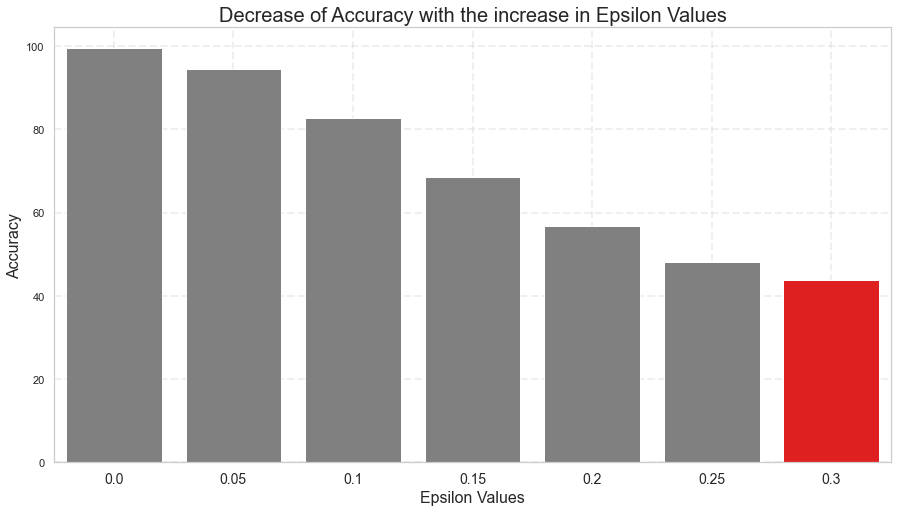

In [16]:
_plot_epsilons_accuracy(x = fgm_sets['Epsilon'], y= fgm_sets['Accuracy'], title='Decrease of Accuracy with the increase in Epsilon Values' )

In [17]:
fgsm_selected_sets = fgm_sets.sort_values(by='Accuracy', ascending=True).head(3)
fgsm_selected_sets

,Epsilon,Accuracy
6,0.30,43.9
5,0.25,48.1
4,0.20,56.8


## 1.4: Visualizing the results (7 Points)

* Please chose one sample for each class (for example the first when iterating the test data) and plot the (ten) adversarial examples as well as the predicted label (before and after the attack)

* Please repeat the visualization for the three sets you have created 

In [19]:
# template code (Please feel free to change this)
# (each column corresponds to one attack method)
# col_titles = ['Ori','FGSM','Method 1', 'Method 2'] 
# nsamples = 10
# nrows = nsamples
# ncols = len(col_titles)

# fig, axes = plt.subplots(nrows,ncols,figsize=(8,12))  # create the figure with subplots
# [ax.set_axis_off() for ax in axes.ravel()]  # remove the axis

# for ax, col in zip(axes[0], col_titles): # set up the title for each column
#     ax.set_title(col,fontdict={'fontsize':18,'color':'b'})

# for i in range(nsamples):
#     axes[i,0].imshow(images_ori[i])
#     axes[i,1].imshow(adv_FGSM[i])
#     axes[i,2].imshow(adv_Method1[i])
#     axes[i,3].imshow(adv_Method2[i])

def visualize_specific_predictions(specific_predictions):
    target_values = []
    predicted_values = []
    figure = plt.figure(figsize=(20, 8))
    columns = 4
    rows = 3
    axs = []
    for index, (images, attacks, targets, w_preds_before_attack, w_preds_after_attack) in list(enumerate(specific_predictions))[:12]:
        with warnings.catch_warnings(record=True):
            axs.append( figure.add_subplot(rows, columns, index+1) )
            axs[-1].set_title(f'Correct: {targets}, Predicted Before: {w_preds_before_attack}, Predicted After: {w_preds_after_attack}', fontsize=10)
            axs[-1].axis("off")
            plt.imshow(images.cpu().detach().numpy().reshape(28, 28),cmap="gray")
            plt.imshow(attacks.cpu().detach().numpy().reshape(28, 28),cmap="gray")
    plt.show()
    

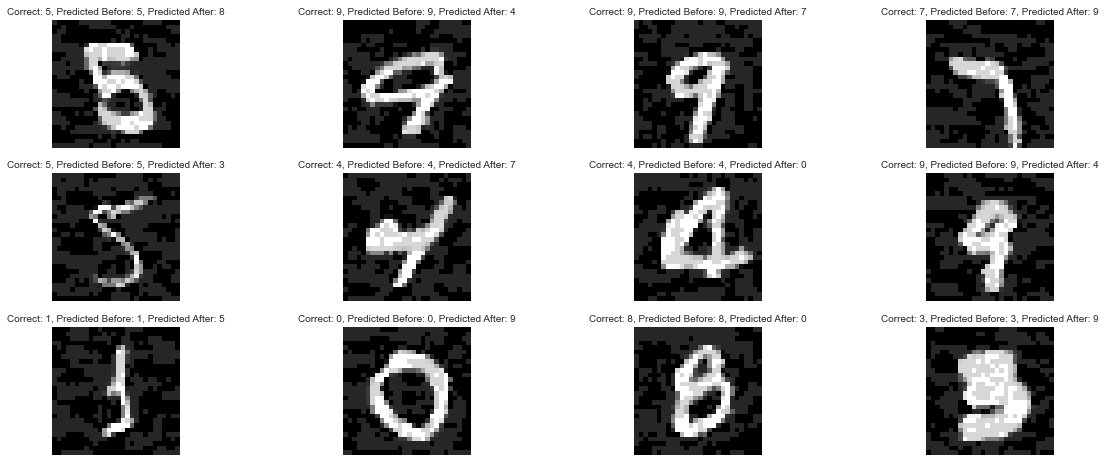

In [20]:
visualize_specific_predictions(predictions[fgm_sets.query('Epsilon==0.15').index.item()])

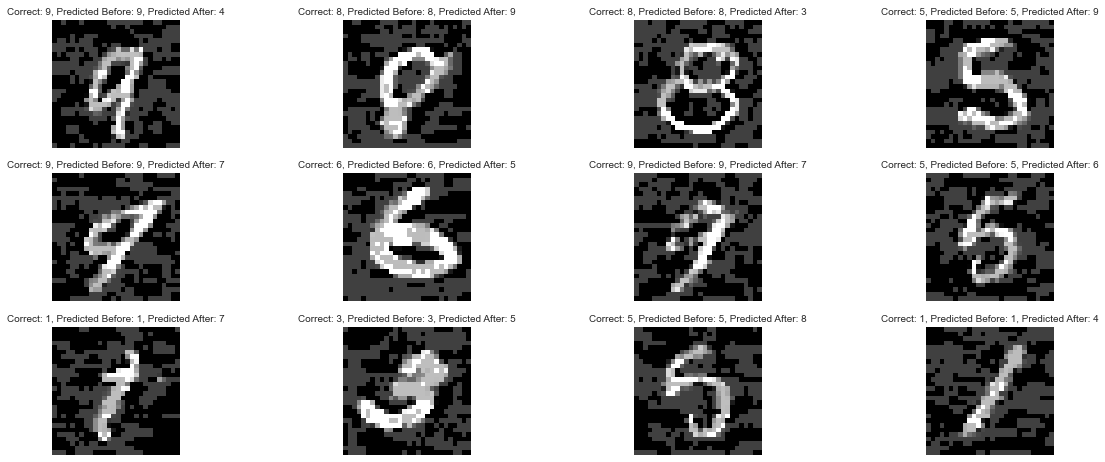

In [21]:
visualize_specific_predictions(predictions[fgm_sets.query('Epsilon==0.25').index.item()])

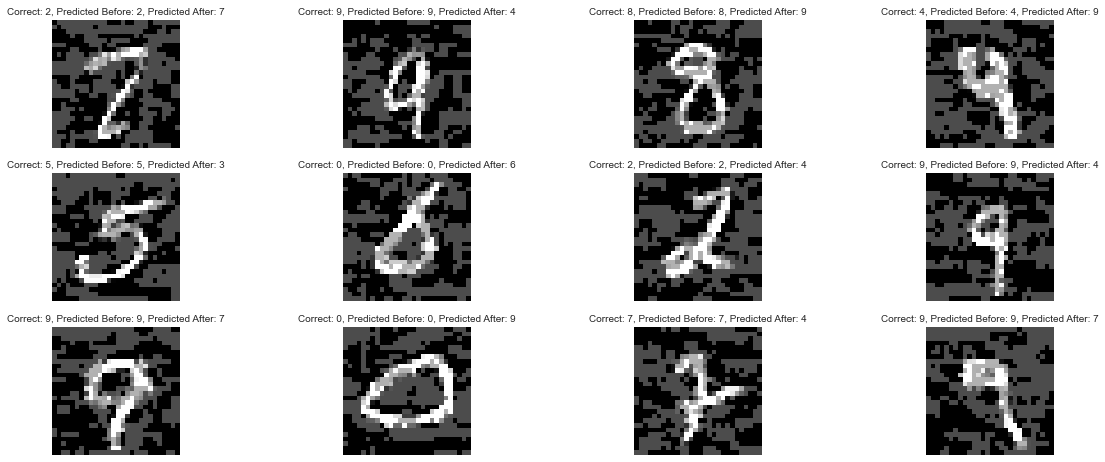

In [22]:
visualize_specific_predictions(predictions[fgm_sets.query('Epsilon==0.3').index.item()])

## 1.5: Analyzing the results (5 Points)

Please write a brief summary of your findings.  

* Does the attack always succeed (the model makes wrong prediction on the adversarial sample)? What is the relationship between the attack success rate and the perturbation budget?
* How about the computation cost of the attack? (you can report the time in second) 
* Does the attack require white-box access to the model?
* Feel free to report your results via tables or figures, and mention any other interesting observations 

#### Does the attack always succeed (the model makes wrong prediction on the adversarial sample)? What is the relationship between the attack success rate and the perturbation budget?
No! The attack is very simple and is not strong enough to fool the model and misclassify everytime. From the experiment above we observed that as we increase the perturbation budget values the accuracy starts to decrease drastically. Fro higher perturbation values the attack success rate is very high as **epsilon=0.3** decreased the accuracy of the model to **43.9 percent** from 98.2 percent which evry significant but the attacks made using lower perturbation budgets are not that impactful and have lower attack success rate.

#### How about the computation cost of the attack? (you can report the time in second)
The computation cost of the attack for 1000 examples is around 2 seconds, but depending on the iterations it can increase upto 7 to 8 seconds.

#### Does the attack require white-box access to the model?
A white box attack is where the attacker has complete knowledge and access to the model's architecture, parameters, gradients and loss and FGSM is a white-box attack because it generates adversarial examples by exploiting output gradients and maximzes the loss. 



**Your answers go here**

# 2. Defending an ML model (35 points) 

So far, we have focused on attacking an ML model. In this section, we want you to defend your model. 


## 2.1: Implementing the adversarial training defense (20 Points)

* We would like to ask you to implement the adversarial training defense (https://arxiv.org/pdf/1412.6572.pdf) mentioned in the lecture. 

* You can use the **FGSM adversarial training** method (i.e., train on FGSM examples). 

* You can also check the adversarial training implementation in other papers, e.g., http://proceedings.mlr.press/v97/pang19a/pang19a.pdf 

* Choose a certain **maximum perturbation budget** during training that is in the middle of the range you have experimented with before. 

* We do not require the defense to work perfectly - but what we want you to understand is why it works or why it does not work.

**Hint:** You can save the checkpoint of the defended model as we would need it to for the third part of this exercise.


In [23]:

def _adversarial_training_defense(adversarial=True):
    try:
        model_with_adversarial_force.train()
        train_loss_scores = []
        training_acc_scores = []
        
        for batch_index, (images, targets) in enumerate(train_loader):
            images, targets = images.to(set_device), targets.to(set_device)
            images.requires_grad = True 
            
            outputs = model_with_adversarial_force(images)
            loss = criterion(outputs, targets)
            fgsm_params['epsilon'] = random.choice([0.1, 0.12, 0.15, 0.17, 0.18, 0.2])
            
            if adversarial:
                loss.backward()
                model_with_adversarial_force.zero_grad()
                loss = criterion(model_with_adversarial_force(images), targets)
                attack_images = fgsm_attack(images, fgsm_params['epsilon'], fgsm_params['clip_min'], fgsm_params['clip_max'])
                objective = 0.5*loss + 0.5*criterion(model_with_adversarial_force(attack_images), targets)
            train_loss_scores.append(objective.item())
            _, preds = torch.max(model_with_adversarial_force(images), 1)    
            _, advpreds = torch.max(model_with_adversarial_force(attack_images), 1)
            acc = len((preds == targets).nonzero(as_tuple=True)[0])/targets.shape[0]*100
            advpreds_acc = len((advpreds == targets).nonzero(as_tuple=True)[0])/targets.shape[0]*100
            training_acc_scores.append((acc+advpreds_acc)/2)
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                
            if (batch_index+1) % 100 == 0:
                print(f"Step : [{batch_index+1}/{len(train_loader)}] | Loss : {loss.item()} ")
        
        model_with_adversarial_force.eval()
        validation_acc_scores = []
        validation_loss_scores = []
        
        for images, targets in iter(validation_loader):
            images, targets = images.to(set_device), targets.to(set_device)
            images.requires_grad = True 
            outputs = model_with_adversarial_force(images)
            loss = criterion(outputs, targets)
            fgsm_params['epsilon'] = random.choice([0.1, 0.12, 0.15, 0.17, 0.18, 0.2])
                    
            if adversarial:
                loss.backward()
                model_with_adversarial_force.zero_grad()
                loss = criterion(model_with_adversarial_force(images), targets)
                attack_images = fgsm_attack(images, fgsm_params['epsilon'], fgsm_params['clip_min'], fgsm_params['clip_max'])
                objective = 0.5*loss + 0.5*criterion(model_with_adversarial_force(attack_images), targets)
            validation_loss_scores.append(objective.item())
            _, preds = torch.max(model_with_adversarial_force(images), 1)    
            _, advpreds = torch.max(model_with_adversarial_force(attack_images), 1)
            acc = len((preds == targets).nonzero(as_tuple=True)[0])/targets.shape[0]*100
            advpreds_acc = len((advpreds == targets).nonzero(as_tuple=True)[0])/targets.shape[0]*100
            validation_acc_scores.append((acc+advpreds_acc)/2)

        return sum(training_acc_scores)/len(training_acc_scores), sum(train_loss_scores)/len(train_loss_scores), \
    sum(validation_acc_scores)/len(validation_acc_scores), sum(validation_loss_scores)/len(validation_loss_scores)
    
    except Exception as e:
        print('Error occured in adversarial defense method = ', e)


In [24]:

training_params = {
        'TRAIN_BATCH_SIZE' : 64,
        'TEST_BATCH_SIZE' : 1000,
        'LEARNING_RATE' : 0.001,
        'OPTIMIZER': optim.Adam,
        'NUM_EPOCHS' : 10
}
    
set_device = torch.device('cuda') 
model_with_adversarial_force = CNN_Network(model_params).to(set_device)
print(f'Network structure is: {model_with_adversarial_force.parameters}')
print(f'Total number of parameters: {sum(p.numel() for p in model_with_adversarial_force.parameters())}')

optimizer = training_params['OPTIMIZER'](model_with_adversarial_force.parameters(), lr=training_params['LEARNING_RATE'])
criterion = nn.CrossEntropyLoss().to(set_device)

training_loss_history = []
validation_loss_history = []
training_acc_history = []
validation_acc_history = []
best_accuracy = 0.0

for epoch in range(training_params['NUM_EPOCHS']):
    print(f'Epoch : {epoch}')

    train_err, train_loss, valid_err, valid_loss = _adversarial_training_defense(adversarial=True)
    training_acc_history.append(train_err)
    training_loss_history.append(train_loss)
    validation_acc_history.append(valid_err)
    validation_loss_history.append(valid_loss)
    
    print(f'Training Accuracy of Epoch {epoch} is {training_acc_history[-1]}')
    print(f'Validation Accuracy of Epoch {epoch} is {validation_acc_history[-1]}')
    
    if validation_acc_history[-1]>best_accuracy:
        best_accuracy = validation_acc_history[-1]
        print('Saving the model...')
        torch.save(model_with_adversarial_force.state_dict(), 
                   f"Adversarial_Accuracy_{best_accuracy}_batchsize_{training_params['TRAIN_BATCH_SIZE']}_lr_{training_params['LEARNING_RATE']}.ckpt")


Network structure is: <bound method Module.parameters of CNN_Network(
  (layers): Sequential(
    (0): Conv2d(1, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(160, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(100, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Conv2d(64, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=10, out_features=10, bias=True)
  )
)>
Total number of parameters: 209244
Epoch : 0
Step : [100/750] | Loss : 1.1773141622543335 

### Loss curves: Training Loss vs Validation Loss Per Epoch During Adversarial Learning

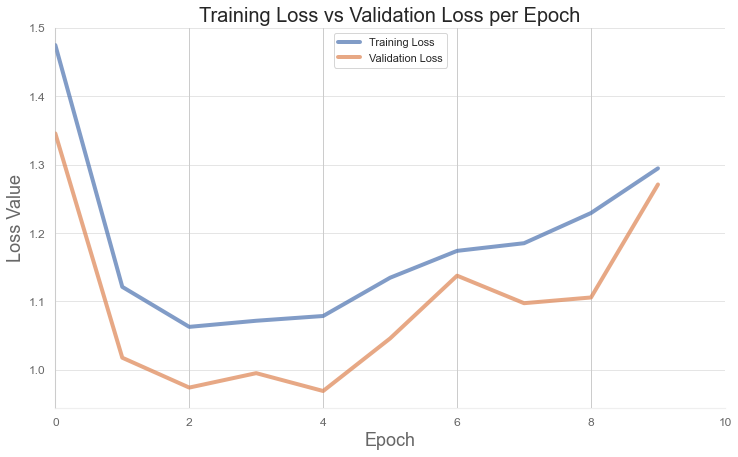

In [33]:

df = pd.DataFrame({'Training Loss':training_loss_history, 'Validation Loss':validation_loss_history})
df.plot(linewidth=4, alpha=0.7, figsize=(12,7), label='Loss')
plt.xlim([0,10])
# plt.ylim(-20,100)
plt.title('Training Loss vs Validation Loss per Epoch', fontsize=20)
plt.grid(axis='y', alpha=.5)
plt.yticks(fontsize=12, alpha=.7)
plt.xticks(fontsize=12, alpha=.7)
plt.xlabel('Epoch', fontsize=18, alpha=.7)
plt.ylabel('Loss Value', fontsize=18, alpha=.7)
# Lighten borders
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.0)
plt.gca().spines["left"].set_alpha(.3)

plt.legend(loc='upper center')
plt.show()


### Accuracy curves: Training Accuracy vs Validation Accuracy Per Epoch During Adversarial Learning

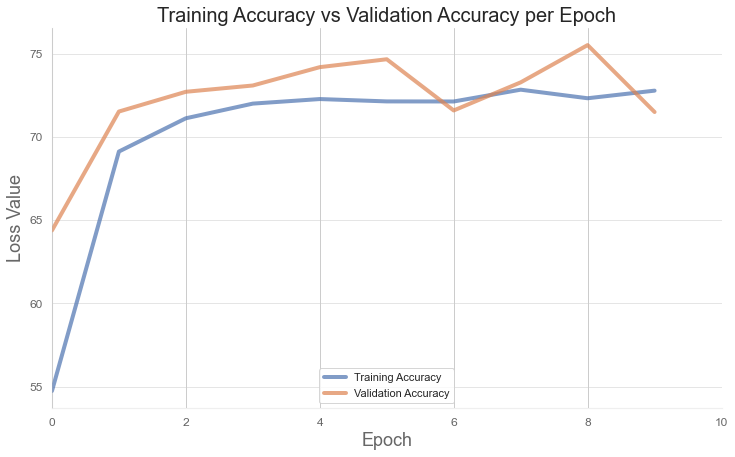

In [34]:

df = pd.DataFrame({'Training Accuracy':training_acc_history, 'Validation Accuracy':validation_acc_history})
df.plot(linewidth=4, alpha=0.7, figsize=(12,7), label='Loss')
plt.xlim([0,10])
# plt.ylim(-20,100)
plt.title('Training Accuracy vs Validation Accuracy per Epoch', fontsize=20)
plt.grid(axis='y', alpha=.5)
plt.yticks(fontsize=12, alpha=.7)
plt.xticks(fontsize=12, alpha=.7)
plt.xlabel('Epoch', fontsize=18, alpha=.7)
plt.ylabel('Loss Value', fontsize=18, alpha=.7)
# Lighten borders
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.0)
plt.gca().spines["left"].set_alpha(.3)

plt.legend(loc='lower center')
plt.show()


## 2.2: Evaluation (10 Points)

* Craft adversarial examples using the **defended** model. This entails at least 1,000 examples crafted via FGSM. 
    * Create one set using a budget that is **less than (within)** the one used in training.
    * Create another set using a budget that is **higher than** the one used in training. 
    * You can use two values of epsilons from question 1.3 
    
* Evaluate the **defended** model on these two adversarial examples sets. 


> For evaluation, since I trained my model with the range of budget **min = 0.1 to max = 0.2** I will take one value less than within this range which is **0.05** and another which is higher than the range on which we have trained which is **0.3**, For the sake of observations and to investigate any highlighting pattern I will also be generating helper sets using the budget values near to the selected budget values. 

In [1]:
### budget values selected for generating 1000 samples via FGSM 
epsilons = [0, 0.05, 0.06, 0.07, 0.25, 0.26, 0.3]

> In evaluation I have also estimated other image similarity metrics like **Peak Signal-to-Noise Ratio (PSNR), Mean Squared Error (MSE), Spectral Angle Mapper (SAM), Visual Information Fidelity (VIF), Structural Similarity Index (SSIM) and Universal Quality Image Index (UQI)** to evaluate the adversarial examples by measuring the images quality being exploited since the attack we implement corrupts gradients and feature maps our model and degrades the quality of the input image as FGSM attack makes perturbations such that the images are misclassified.

> This has been observed that similarity metrics can also be used to highlight the presence of an adversarial attack in an image when compared with its benign counterpart. Thus, these scores can be a measure to quantify the amount of perturbations brought in by these attacks.

**Sewar Library** is used to quantify how dissimilar the regeneration is for every set with different budget value.
https://pypi.org/project/sewar/

In [291]:

def _evaluate(model):
    try:
        predictions = []
        acc_scores = []
        mse_scores = []
        psnr_scores = []
        ssim_scores = []
        uqi_scores = []
        sam_scores = []
        vifp_scores = []

        for epsilon in tqdm(epsilons):
            
            (images, targets) = next(iter(test_loader))
            images, targets = images.to(set_device), targets.to(set_device)  
            images.requires_grad = True 
            
            loss = criterion(model(images), targets)
            model.zero_grad()
            loss.backward()
            
            attack_images = fgsm_attack(images, epsilon, fgsm_params['clip_min'], fgsm_params['clip_max'])
            _, _preds = torch.max(model(images),1)
            _, _preds_after_attack = torch.max(model(attack_images),1)
            acc_images = (len((_preds == targets).nonzero(as_tuple=True)[0])/targets.shape[0])*100
            acc_attack_images = (len((_preds == targets).nonzero(as_tuple=True)[0])/targets.shape[0])*100
            # indicies = (_preds_after_attack != targets).nonzero(as_tuple=True)[0]
            # predictions.append(zip(images[indicies], attack_images[indicies], targets[indicies], _preds_before_attack[indicies], _preds_after_attack[indicies]))
            acc_scores.append((acc_images+acc_attack_images)/2)
            
            mse_scores.append(mse(images.cpu().detach().numpy(),attack_images.cpu().detach().numpy()))
            psnr_scores.append(psnr(images.cpu().detach().numpy(),attack_images.cpu().detach().numpy(), MAX=1))
            ssim_scores.append(ssim(attack_images.cpu().view(1000, -1).detach().numpy(),images.cpu().view(1000, -1).detach().numpy(), MAX=1))
            uqi_scores.append(uqi(attack_images.cpu().view(1000, -1).detach().numpy(),images.cpu().view(1000, -1).detach().numpy()))
            sam_scores.append(sam(attack_images.cpu().view(1000, -1).detach().numpy(),images.cpu().view(1000, -1).detach().numpy()))
            vifp_scores.append(vifp(images.cpu().view(1000, -1).detach().numpy(),attack_images.cpu().view(1000, -1).detach().numpy())
            print(f"Epsilon: {epsilon}\tTest Accuracy  = {acc_scores[-1]} % \tMSE = {mse_scores[-1]} \tPSNR = {psnr_scores[-1]}")
        
        variants = pd.DataFrame({'Epsilon': epsilons, 'Test Accuracy': acc_scores, 'MSE': mse_scores, 'PSNR': psnr_scores, 
                                 'UQI': uqi_scores, 'SAM': sam_scores, 'VIFP': vifp_scores, 'SSIM': ssim_scores})
        return variants
    
    except Exception as e:
            print('Error occured in _evaluate_and_attack method = ', e)    
            

In [292]:
variants = _evaluate(model_with_adversarial_force)

 14%|████████████                                                                        | 1/7 [00:04<00:25,  4.18s/it]

Epsilon: 0	Test Accuracy  = 98.9 % 	MSE = 0.0 	PSNR = inf


 29%|████████████████████████                                                            | 2/7 [00:08<00:20,  4.17s/it]

Epsilon: 0.05	Test Accuracy  = 98.5 % 	MSE = 0.0013819785526218938 	PSNR = 28.594986968679272


 43%|████████████████████████████████████                                                | 3/7 [00:12<00:16,  4.14s/it]

Epsilon: 0.06	Test Accuracy  = 98.9 % 	MSE = 0.0019803841312485567 	PSNR = 27.032505623136892


 57%|████████████████████████████████████████████████                                    | 4/7 [00:16<00:12,  4.11s/it]

Epsilon: 0.07	Test Accuracy  = 98.9 % 	MSE = 0.0026985291180676545 	PSNR = 25.688728913849896


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:20<00:08,  4.13s/it]

Epsilon: 0.25	Test Accuracy  = 99.0 % 	MSE = 0.033359462094574556 	PSNR = 14.767809607693547


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:24<00:04,  4.11s/it]

Epsilon: 0.26	Test Accuracy  = 98.3 % 	MSE = 0.03597577665004128 	PSNR = 14.439898216808224


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:28<00:00,  4.12s/it]

Epsilon: 0.3	Test Accuracy  = 98.9 % 	MSE = 0.04762245875120187 	PSNR = 13.221881856948306


> We can verify the results of the similarity metrics that is it is **0 for MSE, infinity for PSNR, 1 for UQI, 0 for SAM and 1 for VIFP**; indicating that no perturbations were included in the attack images as **epsilon value was 0**. As we have increased the budget a little by setting the values like **[0.05, 0.06, 0.07]** which is less than the range on which we trained our model we can observe that images were degraded as the **PSNR value has been drastically decreased from infinity to some values like 28~25 dB** and **MSE was increased a little bit**  and **SSIM scores were increased** as well. However, **VIFP scores indicate that perturbations addded has not impacted its values** indicating the Visual Information Fidelity is prettty similar for those images. 

> As we have used the higher budget values like **[0.25, 0.26, 0.3]** we observed the PSNR, MSE and SAM scores significantly chnage and has noticebly increased indicating the strong attack in the images.

In [293]:
variants

,Epsilon,Test Accuracy,MSE,PSNR,UQI,SAM,VIFP,SSIM
0,0.00,98.9,0.000000,inf,1.000000,0.000000,1.000000,"(1.0, 1.0)"
1,0.05,98.5,0.001382,28.594987,0.607641,0.109767,1.071939,"(0.7214034811935927, 0.8951742891973873)"
2,0.06,98.9,0.001980,27.032506,0.591711,0.131917,1.083622,"(0.6951114126353075, 0.8673449635816329)"
3,0.07,98.9,0.002699,25.688729,0.587335,0.153094,1.093263,"(0.6821999105896961, 0.8476766685986323)"
4,0.25,99.0,0.033359,14.767810,0.438606,0.541088,0.942297,"(0.47271671375970054, 0.5983123566028477)"
5,0.26,98.3,0.035976,14.439898,0.434986,0.555325,0.919320,"(0.4664841923551302, 0.5920398154097339)"
6,0.30,98.9,0.047622,13.221882,0.408250,0.635503,0.801118,"(0.4251339758650218, 0.5436665489884728)"


In [294]:
acc_FGSM1 = fgm_sets.query('Epsilon==0.05')['Accuracy'].item()
acc_FGSM_defend1 = variants.query('Epsilon==0.05')['Test Accuracy'].item()

acc_FGSM2 = fgm_sets.query('Epsilon==0.3')['Accuracy'].item()
acc_FGSM_defend2 = variants.query('Epsilon==0.3')['Test Accuracy'].item()

print('Accuracy on the lower-budget adversarial samples (FGSM) %.2f'%acc_FGSM1)
print('Accuracy on the lower-budget adversarial samples (FGSM) after defense %.2f'%acc_FGSM_defend1)

print('Accuracy on the higher-budget adversarial samples (FGSM) %.2f'%acc_FGSM2)
print('Accuracy on the higher-budget adversarial samples (FGSM) after defense %.2f'%acc_FGSM_defend2)

Accuracy on the lower-budget adversarial samples (FGSM) 94.60
Accuracy on the lower-budget adversarial samples (FGSM) after defense 98.50
Accuracy on the higher-budget adversarial samples (FGSM) 43.90
Accuracy on the higher-budget adversarial samples (FGSM) after defense 98.90


## 2.3 Discussion (5 points)

* How successful was the defense against the attack compared to the undefended model? How do you interpret the difference?
* How did the two sets differ?


#### How successful was the defense against the attack compared to the undefended model? How do you interpret the difference?

- For lower perturbation value **(epsilon=0.05)**, the accuracy of the undefended model was **reduced to 94.60 percent from 99.2 percent** by using the defended model we observed the accuracy increased from **94.6 percent to 98.5 percent** which is quite close to the original testing accuracy score. This concludes that model is robust with atleast lower perturbation budgets.
- For higher perturbation value **(epsilon=0.3)**, the accuracy of the undefended model was reduced to **43.90 percent** from **99.2 percent** which is horrible, but by using the defended model we observed the accuracy increased from **43.90 percent to 98.9 percent** which is quite close to the original testing accuracy score. 

#### How did the two sets differ?
Model is trained within a range of perturbation budget with 0.1 to be the minimum and 0.2 to be the maximum so it will predict the images generated within that range easily but the sets created usining the 0.05 budget and 0.3 budget were not on which the model was trained.
The adversarial examples we have generated using the perturbation budget 0.05 introduced very less perturbations to the images as can be observed by the similarity metrics that these generated samples are pretty close to the real dataset as compare to the sets generated using higher perturbation values like 0.3 where the images are actually very noised down and degraded to an extent where it would actually be very hard for the model to classify them properly. However the model is able to classify the attacks implemented by FGSM attack method.

# 3: I-FGSM attack (35 points) 

* FGSM is one of the simplest and earliest attacks. Since then, many more advanced attacks have been proposed. 
* One of them is the Iterative-FGSM (https://arxiv.org/pdf/1607.02533.pdf), where the attack is repeated multiple times.
* In this part, we ask you to please implement the iterative FGSM attack. 



## 3.1: Implementing the I-FGSM attack (10 Points)

**Hints**: 

* Your code should have an attack loop. At each step, the FGSM attack that you have implemented before is computed using a small step.
* After each step, you should perform a per-pixel clipping to make sure the image is in the allowed range, and that the perturbation is within budget.


In [25]:

def ifgsm_attack(img, targets, model, ifgsm_params):
    small_step = ifgsm_params['EPSILON']/ifgsm_params['STEPS']

    step = 1
    while step <=  ifgsm_params['STEPS']  :
        loss = nn.CrossEntropyLoss()(model(img), targets)
        loss.backward()
        adversary_without_clipping = (img.data + small_step * img.grad.data.sign()) - img
        clipped_delta = torch.clamp(adversary_without_clipping, -ifgsm_params['EPSILON'], ifgsm_params['EPSILON'])
        img.data = torch.clamp(img.data + clipped_delta ,0,1)
        img.grad.data.zero_()
        step+=1
    return img.data


## 3.2: Attack the undefended model (5 Points)

* We will first attack the **undefended model** (i.e., without adversarial training).

* Choose one perturbation budget from Question **1.3** for comparison. 

    * Hint: A simple way to choose the small step is to divide the total budget by the number of steps (e.g., 10).

* Please generate 1000 adversarial examples using the **undefended** model and the **I-FGSM** you implemented. 

* Please compute the accuracy of the adversarial set on the **undefended** model. 

In [190]:
ifgsm_params = {
    'STEPS' : 8,
    'EPSILON' : 0.1
}

def _attack_and_evaluate(model):
    try:
        predictions = []
        acc_scores = []
        mse_scores = []
        psnr_scores = []
        ssim_scores = []
        uqi_scores = []
        sam_scores = []
        vifp_scores = []

        for epsilon in range(1):
            
            (i, targets) = next(iter(test_loader))
            i, targets = i.to(device), targets.to(device)  
            i.requires_grad = True
            
            attack_images = ifgsm_attack(i, targets, model, ifgsm_params)
            _, _preds = torch.max(model(i),1)
            _, _preds_after_attack = torch.max(model(attack_images),1)
            acc_images = (len((_preds == targets).nonzero(as_tuple=True)[0])/targets.shape[0])*100
            acc_attack_images = (len((_preds == targets).nonzero(as_tuple=True)[0])/targets.shape[0])*100
            acc_scores.append((acc_images+acc_attack_images)/2)
            
            mse_scores.append(mse(i.cpu().detach().numpy(),attack_images.cpu().detach().numpy()))
            psnr_scores.append(psnr(i.cpu().detach().numpy(),attack_images.cpu().detach().numpy(), MAX=1))
            # ssim_scores.append(ssim(attack_images.cpu().view(1000, -1).detach().numpy(),i.cpu().view(1000, -1).detach().numpy(), MAX=1))
            # uqi_scores.append(uqi(attack_images.cpu().view(1000, -1).detach().numpy(),i.cpu().view(1000, -1).detach().numpy()))
            # sam_scores.append(sam(attack_images.cpu().view(1000, -1).detach().numpy(),i.cpu().view(1000, -1).detach().numpy()))
            # vifp_scores.append(vifp(attack_images.cpu().view(1000, -1).detach().numpy(),i.cpu().view(1000, -1).detach().numpy()))
#             print(f"Epsilon: {epsilon}\tTest Accuracy  = {acc_scores[-1]} % \tMSE = {mse_scores[-1]} \tPSNR = {psnr_scores[-1]}")
        
        variants = pd.DataFrame({'Epsilon': ifgsm_params['EPSILON'], 'Test Accuracy': acc_scores, })
                                 # 'MSE': mse_scores, 'PSNR': psnr_scores, 
                                 # 'UQI': uqi_scores, 'SAM': sam_scores, 'VIFP': vifp_scores, 'SSIM': ssim_scores})
        return variants
    
    except Exception as e:
            print('Error occured in _evaluate_and_attack method = ', e)    
            

In [191]:
variants = _attack_and_evaluate(undefended_model)

In [192]:
variants

,Epsilon,Test Accuracy
0,0.1,62.5


### 3.2.1: Findings and comparison with FGSM (8 points)

##### Please report your findings. How successful was the attack? <br/>
For **(perturbation budget = 0.1)** with undefended model** the attack was able to decrease the accuracy **by 62.5 percent**. Attack was successful as with higher perturbation budget it was able to decrease the accuracy.

##### What do you expect when increasing the number of steps? (you can experiment with different parameters of the attack and report your findings) <br/>
With the increase of the the steps the attacks is more stronger and accuracy is declined even with lower perturbation value. 

##### Compare with the basic FGSM. Using the same perturbation budget and using the same model, which attack is more successful? Why do you think this is the case? What about the computation time?
The same undefended model on FGSM attacks decreased the accuracy by 82.9 percent but with IFGSM it was declined further upto 65 percent.


## 3.3: Attack the defended model (5 poinst) 

* In the previous question, we attacked the **undefended model**. 

* Now, we want to explore how successful the previous implemented defense (FGSM adversarial training) is againts this new attack. (we will not implement a new defense here, we will be reusing your previous checkpoint of the **defended model**)


* Use the **defended model** to create one set of adversarial examples. Use a perturbation budget from Question **2.2** for comparison.  

In [162]:
variants = _attack_and_evaluate(model_with_adversarial_force)

In [163]:
variants

,Epsilon,Test Accuracy
0,0.05,92.1875


### 3.3.1: Discussion (7 points) 

#### Please report your results. How successful was the attack on the defended model?** <br/>
For **(perturbation budget = 0.05)** with undefended model** the attack was able to decrease the accuracy **by 69 percent** whereas with **defended model** we were able to keep up with **92.187 percent**. Attack was not that strong with lower perturbation value but quite successful with higher perturbation budget.

#### Compare it with the success of the FGSM attack on the defended model. What do you observe? How do you interpret the difference?** <br/>
The accuracy on the lower-budget adversarial samples (FGSM) after defense was **98.50 percent**. 
The I-FGSM attack was better and stronger than FGSM on defended model as it was able to compromise the accuracy more as compare to FGSM.

#### How do you think you can improve the defense against I-FGSM attack?

#### Feel free to state any interesting findings you encountered during this project.
- Theses attacks are very simple and one cannot guarantee the robustness of the network model trained using the adversarial examples generated from these methods against stronger attacks.
- We have focused on the the ability to successfully train our model against strong adversaries but we have not imporvised on the capacity of the model which is also crucial for robustness.